In [1]:
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

Using matplotlib backend: Qt5Agg


In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
print(sys.path)

['', 'C:\\Users\\seanm\\Anaconda3\\python35.zip', 'C:\\Users\\seanm\\Anaconda3\\DLLs', 'C:\\Users\\seanm\\Anaconda3\\lib', 'C:\\Users\\seanm\\Anaconda3', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\seanm\\.ipython', 'C:\\Users\\seanm\\OneDrive\\Documents\\Research\\TauHybridSolver\\GillesPy2']


In [3]:
import math
import gillespy2
from gillespy2.basic_tau_hybrid_solver import BasicTauHybridSolver

Unable to use Cython optimized SSA:
Error:No module named 'cython_ssa_solver'


In [4]:

class SimpleHybridModel(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Simple_Hybrid_Model")

            
            #Species
            A = gillespy2.Species(name='A', initial_value=0)
            V = gillespy2.Species(name='V', initial_value=0, deterministic=True)

            self.add_species([A, V])
            
            #parameters
            rate1 = gillespy2.Parameter(name='rate1', expression= 20.0)
            rate2 = gillespy2.Parameter(name='rate2', expression= 10.0)
            rate_rule1 = gillespy2.RateRule(V, "sin(t)")
            self.add_parameter([rate1, rate2])
            self.add_rate_rule(rate_rule1)
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={}, products={A:1},
                   propensity_function="rate1 * V")
            
            r2 = gillespy2.Reaction(name="r2",reactants={A:1}, products={},
                    rate=rate2)
            
            self.add_reaction([r1,r2])
            self.timespan(numpy.linspace(0,100, 1001))

In [5]:
model = SimpleHybridModel()

In [6]:
%time results = model.run(solver=BasicTauHybridSolver(), show_labels=True, debug=False)
# import cProfile

# cProfile.run('model.run(solver=BasicTauHybridSolver(), show_labels=True, debug=False)', sort='cumulative')

Wall time: 1.09 s


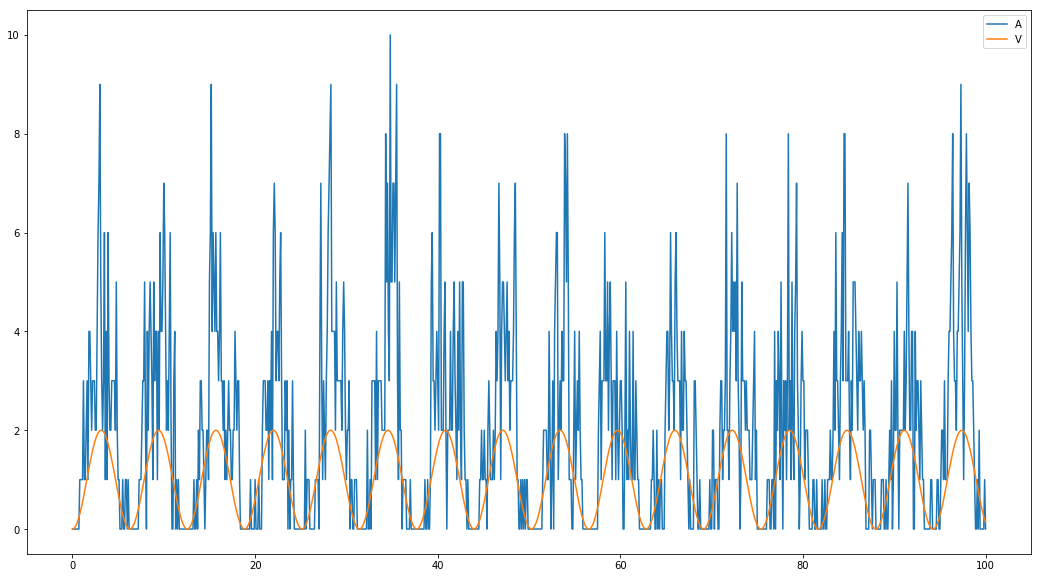

In [7]:
plt.figure(figsize=(18,10))
plt.plot(results['time'], results['A'], label='A')
plt.plot(results['time'], results['V'], label='V')
plt.legend(loc='best')


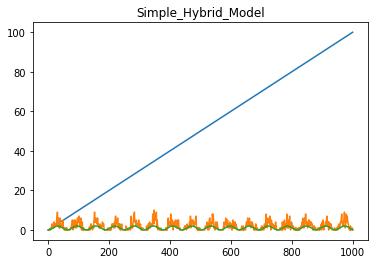

In [8]:
model.plot(results)